In [18]:
import os
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
from tqdm.notebook import tqdm  # Use tqdm.notebook for Jupyter Notebook

In [29]:
# Parameters
total_samples = 10 # low for testing, should be on 20k
batch_size = 16
num_epochs = 100
learning_rate = 1e-3
commitment_cost = 0.25
hidden_channels = 128
embedding_dim = 64
num_embeddings = 512

# Directories containing the images
dataset_dirs = [
    '/Users/ls/Library/CloudStorage/GoogleDrive-l.schrage@northeastern.edu/Shared drives/Drawing Participation/Million Neighborhoods/Generated Images/ma-boston/parcels',
    '/Users/ls/Library/CloudStorage/GoogleDrive-l.schrage@northeastern.edu/Shared drives/Drawing Participation/Million Neighborhoods/Generated Images/nc-charlotte/parcels', 
    '/Users/ls/Library/CloudStorage/GoogleDrive-l.schrage@northeastern.edu/Shared drives/Drawing Participation/Million Neighborhoods/Generated Images/ny-manhattan/parcels', 
    '/Users/ls/Library/CloudStorage/GoogleDrive-l.schrage@northeastern.edu/Shared drives/Drawing Participation/Million Neighborhoods/Generated Images/pa-pittsburgh/parcels'  
]

# Output directory for saving the trained model
output_dir = '/Users/ls/Library/CloudStorage/GoogleDrive-l.schrage@northeastern.edu/Shared drives/Drawing Participation/Million Neighborhoods/Auto-Encoder/Trained Model'  # Replace with the actual path to your output directory

# Ensure the output directory exists
os.makedirs(output_dir, exist_ok=True)

In [30]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((16, 16)),  # Resize to a fixed size
    transforms.ToTensor(),        # Convert to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

# Collect all image paths
all_image_paths = []
for dataset_dir in dataset_dirs:
    for root, _, files in os.walk(dataset_dir):
        for file in files:
            if file.endswith(('.png', '.jpg', '.jpeg')):  # Consider image files only
                all_image_paths.append(os.path.join(root, file))

# Randomly sample the images from the collected paths
sampled_image_paths = random.sample(all_image_paths, total_samples)

# Custom dataset to load images from the sampled paths
class SampledImageDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')  # Ensure image is in RGB format
        if self.transform:
            image = self.transform(image)
        return image, 0  # Returning 0 as a placeholder label

# Create a dataset and dataloader for the sampled images
sampled_dataset = SampledImageDataset(sampled_image_paths, transform=transform)
dataloader = DataLoader(sampled_dataset, batch_size=batch_size, shuffle=True)

# VQ-VAE Model Definition
class Encoder(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_embeddings, embedding_dim):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, hidden_channels, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(hidden_channels, embedding_dim, kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.conv2(x)
        return x

class Decoder(nn.Module):
    def __init__(self, embedding_dim, hidden_channels, out_channels):
        super(Decoder, self).__init__()
        self.conv1 = nn.ConvTranspose2d(embedding_dim, hidden_channels, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.ConvTranspose2d(hidden_channels, out_channels, kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = torch.tanh(self.conv2(x))
        return x

class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost):
        super(VectorQuantizer, self).__init__()
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        self.embedding.weight.data.uniform_(-1/self.num_embeddings, 1/self.num_embeddings)
        self.commitment_cost = commitment_cost

    def forward(self, x):
        # Quantize
        flattened = x.view(-1, self.embedding_dim)
        distances = torch.cdist(flattened, self.embedding.weight)
        encoding_indices = torch.argmin(distances, dim=1)
        quantized = self.embedding(encoding_indices).view(x.size())

        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), x)
        q_latent_loss = F.mse_loss(quantized, x.detach())
        loss = q_latent_loss + self.commitment_cost * e_latent_loss

        quantized = x + (quantized - x).detach()  # Straight-through estimator

        return quantized, loss, encoding_indices

class VQVAE(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_embeddings, embedding_dim, commitment_cost):
        super(VQVAE, self).__init__()
        self.encoder = Encoder(in_channels, hidden_channels, num_embeddings, embedding_dim)
        self.decoder = Decoder(embedding_dim, hidden_channels, in_channels)
        self.vq_layer = VectorQuantizer(num_embeddings, embedding_dim, commitment_cost)

    def forward(self, x):
        encoded = self.encoder(x)
        quantized, vq_loss, _ = self.vq_layer(encoded)
        decoded = self.decoder(quantized)
        return decoded, vq_loss

# Initialize model, optimizer, and loss function
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VQVAE(in_channels=3, hidden_channels=hidden_channels, num_embeddings=num_embeddings,
              embedding_dim=embedding_dim, commitment_cost=commitment_cost).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

# Training Loop with Progress Bar
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    # Use tqdm to display progress bar
    for images, _ in tqdm(dataloader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False):
        images = images.to(device)

        # Forward pass
        reconstructed, vq_loss = model(images)
        recon_loss = criterion(reconstructed, images)
        loss = recon_loss + vq_loss

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(dataloader)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}")

# Save the trained model
model_save_path = os.path.join(output_dir, "vqvae_model.pth")
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Epoch 1/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1/100], Loss: 0.1537


Epoch 2/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2/100], Loss: 0.1602


Epoch 3/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [3/100], Loss: 0.1804


Epoch 4/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [4/100], Loss: 0.2208


Epoch 5/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [5/100], Loss: 0.2906


Epoch 6/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [6/100], Loss: 0.3965


Epoch 7/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [7/100], Loss: 0.5406


Epoch 8/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [8/100], Loss: 0.7218


Epoch 9/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [9/100], Loss: 0.9325


Epoch 10/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [10/100], Loss: 1.1507


Epoch 11/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [11/100], Loss: 1.3331


Epoch 12/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [12/100], Loss: 1.4330


Epoch 13/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [13/100], Loss: 1.4218


Epoch 14/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [14/100], Loss: 1.3054


Epoch 15/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [15/100], Loss: 1.1175


Epoch 16/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [16/100], Loss: 0.8990


Epoch 17/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [17/100], Loss: 0.6863


Epoch 18/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [18/100], Loss: 0.5079


Epoch 19/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [19/100], Loss: 0.3824


Epoch 20/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [20/100], Loss: 0.3212


Epoch 21/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [21/100], Loss: 0.3144


Epoch 22/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [22/100], Loss: 0.3328


Epoch 23/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [23/100], Loss: 0.3526


Epoch 24/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [24/100], Loss: 0.3691


Epoch 25/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [25/100], Loss: 0.3856


Epoch 26/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [26/100], Loss: 0.4086


Epoch 27/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [27/100], Loss: 0.4431


Epoch 28/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [28/100], Loss: 0.4892


Epoch 29/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [29/100], Loss: 0.5438


Epoch 30/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [30/100], Loss: 0.6023


Epoch 31/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [31/100], Loss: 0.6601


Epoch 32/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [32/100], Loss: 0.7120


Epoch 33/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [33/100], Loss: 0.7548


Epoch 34/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [34/100], Loss: 0.7864


Epoch 35/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [35/100], Loss: 0.8073


Epoch 36/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [36/100], Loss: 0.8192


Epoch 37/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [37/100], Loss: 0.8255


Epoch 38/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [38/100], Loss: 0.8288


Epoch 39/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [39/100], Loss: 0.8319


Epoch 40/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [40/100], Loss: 0.8367


Epoch 41/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [41/100], Loss: 0.8451


Epoch 42/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [42/100], Loss: 0.8585


Epoch 43/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [43/100], Loss: 0.8783


Epoch 44/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [44/100], Loss: 0.9042


Epoch 45/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [45/100], Loss: 0.9354


Epoch 46/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [46/100], Loss: 0.9714


Epoch 47/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [47/100], Loss: 1.0118


Epoch 48/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [48/100], Loss: 1.0563


Epoch 49/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [49/100], Loss: 1.1048


Epoch 50/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [50/100], Loss: 1.1577


Epoch 51/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [51/100], Loss: 1.2143


Epoch 52/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [52/100], Loss: 1.2724


Epoch 53/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [53/100], Loss: 1.3310


Epoch 54/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [54/100], Loss: 1.3891


Epoch 55/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [55/100], Loss: 1.4456


Epoch 56/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [56/100], Loss: 1.4990


Epoch 57/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [57/100], Loss: 1.5490


Epoch 58/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [58/100], Loss: 1.5949


Epoch 59/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [59/100], Loss: 1.6374


Epoch 60/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [60/100], Loss: 1.6745


Epoch 61/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [61/100], Loss: 1.7047


Epoch 62/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [62/100], Loss: 1.7265


Epoch 63/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [63/100], Loss: 1.7417


Epoch 64/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [64/100], Loss: 1.7526


Epoch 65/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [65/100], Loss: 1.7584


Epoch 66/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [66/100], Loss: 1.7598


Epoch 67/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [67/100], Loss: 1.7550


Epoch 68/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [68/100], Loss: 1.7473


Epoch 69/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [69/100], Loss: 1.7369


Epoch 70/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [70/100], Loss: 1.7247


Epoch 71/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [71/100], Loss: 1.7099


Epoch 72/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [72/100], Loss: 1.6920


Epoch 73/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [73/100], Loss: 1.6703


Epoch 74/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [74/100], Loss: 1.6444


Epoch 75/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [75/100], Loss: 1.6146


Epoch 76/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [76/100], Loss: 1.5832


Epoch 77/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [77/100], Loss: 1.5505


Epoch 78/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [78/100], Loss: 1.5184


Epoch 79/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [79/100], Loss: 1.4879


Epoch 80/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [80/100], Loss: 1.4607


Epoch 81/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [81/100], Loss: 1.4377


Epoch 82/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [82/100], Loss: 1.4193


Epoch 83/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [83/100], Loss: 1.4059


Epoch 84/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [84/100], Loss: 1.3964


Epoch 85/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [85/100], Loss: 1.3914


Epoch 86/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [86/100], Loss: 1.3899


Epoch 87/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [87/100], Loss: 1.3911


Epoch 88/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [88/100], Loss: 1.3935


Epoch 89/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [89/100], Loss: 1.3977


Epoch 90/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [90/100], Loss: 1.4032


Epoch 91/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [91/100], Loss: 1.4074


Epoch 92/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [92/100], Loss: 1.4075


Epoch 93/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [93/100], Loss: 1.4051


Epoch 94/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [94/100], Loss: 1.3977


Epoch 95/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [95/100], Loss: 1.3892


Epoch 96/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [96/100], Loss: 1.3746


Epoch 97/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [97/100], Loss: 1.3569


Epoch 98/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [98/100], Loss: 1.3355


Epoch 99/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [99/100], Loss: 1.3120


Epoch 100/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [100/100], Loss: 1.2870
Model saved to /Users/ls/Library/CloudStorage/GoogleDrive-l.schrage@northeastern.edu/Shared drives/Drawing Participation/Million Neighborhoods/Auto-Encoder/Trained Model/vqvae_model.pth


In [23]:
# output the latent vectors (e.g. 1000 dimensional vectors for each image)
vector = model.encoder(images)
print(vector.shape)
output = model.decoder(vector)
print(output.shape)



torch.Size([2, 64, 4, 4])
torch.Size([2, 3, 16, 16])


torch.Size([10, 64, 4, 4])
torch.Size([10, 3, 16, 16])


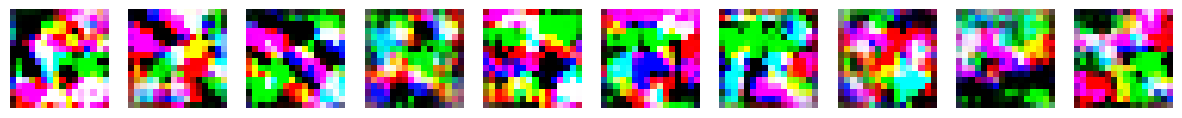

In [39]:
import matplotlib.pyplot as plt
import torch

# Assuming 'model' and 'images' are already defined
# output the latent vectors (e.g. 1000 dimensional vectors for each image)
vector = model.encoder(images)
print(vector.shape)
output = model.decoder(vector)
print(output.shape)

# Convert the output tensor to a NumPy array
output_np = output.detach().cpu().numpy()

# Plot the output images
# Assuming the output shape is (batch_size, channels, height, width)
batch_size = output_np.shape[0]
fig, axes = plt.subplots(1, batch_size, figsize=(15, 5))

for i in range(batch_size):
    img = output_np[i].transpose(1, 2, 0)  # Convert from (C, H, W) to (H, W, C)
    img = (img - img.min()) / (img.max() - img.min())  # Normalize to [0, 1]
    axes[i].imshow(img)
    axes[i].axis('off')

plt.show()

In [25]:
# compare with this output -> plot with matplot lib or openCV
output = model(images)
print(output[0].shape)

torch.Size([2, 3, 16, 16])
